# !pip3 install tensorflow==2.1.0 pillow matplotlib
!pip3 install git+https://github.com/am1tyadav/tfutils.git

In [ ]:
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to /tmp/pip-req-build-3h67t_ns
  Running command git clone -q https://github.com/am1tyadav/tfutils.git /tmp/pip-req-build-3h67t_ns
  Created wheel for tfutils: filename=tfutils-0.0.1-cp36-none-any.whl size=6442 sha256=d2e684f270c5f95dfdb2f4b9a958c98d69f03c5b9ecd00ef9fff057b2d361e64
  Stored in directory: /tmp/pip-ephem-wheel-cache-ez8ozn4w/wheels/fc/ae/41/9164f4ea031c0d70c13ba0d3fa9ab01c6783b36d6324db18ec
Successfully built tfutils


In [ ]:
import tensorflow as tf
import numpy as np
import os
import tfutils
import requests

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

In [ ]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)

x = np.concatenate([x_train, x_test], axis=0)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

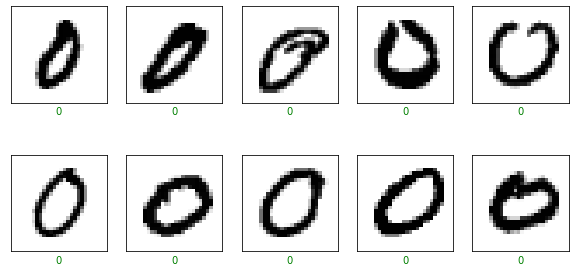

In [ ]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1)))

In [ ]:
discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28 ,28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr = 2e-4, beta_1=0.5)

discriminator.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

In [ ]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(1, )),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    
     Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),
    
     Conv2DTranspose(1, 4, activation='sigmoid'),
    BatchNormalization(),
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

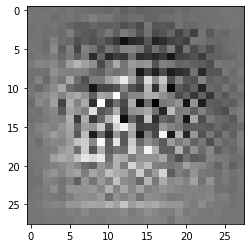

In [ ]:
noise = np.random.randn(1, 1)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap = 'binary')

In [ ]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,    #input to the model
    disc_out        #output of the model after feeding the input, i.e. input_layer
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()  #sequential_3 is generator which generates a random img with (28, 28) pixels and sequential_1 is discriminator

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717029   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,102
Trainable params: 2,716,067
Non-trainable params: 1,028,035
_________________________________________________________________


In [ ]:
epochs = 25
batch_size = 128
steps_per_epoch = int(2*x.shape[0]/batch_size) #in each epoch step only half of the true examples are used, therefore it is multiplied by 2, since we will have twice the number of batches for training set

print('Steps per epoch= ', steps_per_epoch)

Steps per epoch=  107


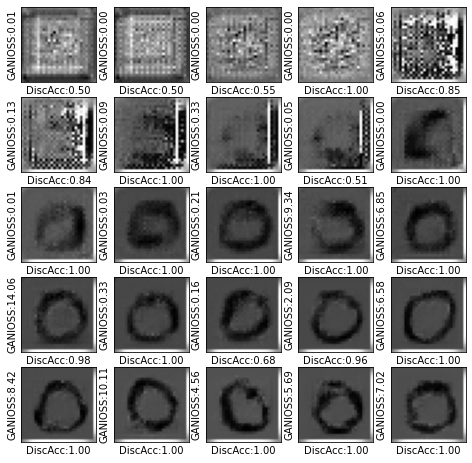

In [ ]:
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(epochs):
    dp.start_of_epoch(e)
    
    for step in range(steps_per_epoch):
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        
        noise = np.random.randn(int(batch_size/2), 1)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0) #axis=0 is row wise
        y_batch = np.array([0]*int(batch_size/2)+[1]*int(batch_size/2))  #[0] for generated(fake) examples, [1] for true examples
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)       #training the discriminator
        discriminator.trainable = False
       
    
        loss,_ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))  #training the generator
        _,acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
    
    noise = np.random.randn(1, 1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28, 28))
    dp.end_of_epoch(gen_image, 'binary', 'DiscAcc:{:.2f}'.format(acc), 'GANlOSS:{:.2f}'.format(loss))